In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pathlib
import os

# Load Data

In [2]:
# get the data directory
data_dir = pathlib.Path(os.getcwd()).parent / "data"
combined_file = data_dir / "processed_data" / "combined_data.nc"

# Load the data
combined = xr.open_dataset(combined_file)

# Baseline Model - Arithmetic Mean

In [3]:
# Convert the time dimension to a pandas datetime format (if not already)
time = combined["time"]

# Define the cutoff date
cutoff_date = time[int(0.9 * len(time))]

# Create a boolean mask for June, July, and August
mask_months = time.dt.month.isin([6, 7, 8])

In [4]:
# Create a boolean mask for dates at or before the cutoff date
train_mask_dates = time <= cutoff_date

# Combine the masks
train_combined_mask = mask_months & train_mask_dates

# Filter the dataset using the combined mask
train_data = combined["tp"].sel(
    time=combined["time"].where(train_combined_mask, drop=True)
)

# If you want to see the resulting filtered data
print(train_data)

<xarray.DataArray 'tp' (time: 114, latitude: 5, longitude: 13)> Size: 30kB
[7410 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 912B 1982-06-01 1982-07-01 ... 2019-08-01
  * latitude   (latitude) float32 20B 37.5 40.0 42.5 45.0 47.5
  * longitude  (longitude) float32 52B -110.0 -107.5 -105.0 ... -82.5 -80.0
    level      float32 4B ...
Attributes:
    long_name:  Total precipitation
    units:      mm


In [5]:
# Calculate the mean of the filtered data
train_mean = train_data.mean(dim="time")

In [6]:
# Calculate MSE and ME
# variance of residuals
train_mse = (
    ((train_data - train_mean) ** 2)
    .mean(dim="time")
    .mean(dim="latitude")
    .mean(dim="longitude")
)
# bias of residuals (mean error)
train_me = (
    (train_data - train_mean)
    .mean(dim="time")
    .mean(dim="latitude")
    .mean(dim="longitude")
)
# standard deviation of residuals
train_rmse = np.sqrt(train_mse)

# Calculate residuals
residuals = train_data - train_mean

# Flatten the residuals to create a 1D array
flattened_residuals = residuals.values.flatten()

Train Mean Squared Error: 1772.727
Train Root Mean Squared Error: 42.103764
Train Mean Error: -1.0789004e-06


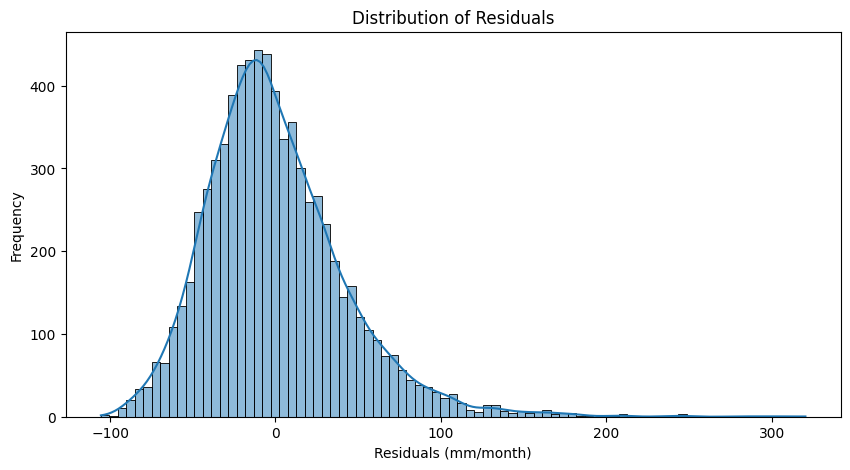

In [7]:
# Print the results
print("Train Mean Squared Error:", train_mse.values)
print("Train Root Mean Squared Error:", train_rmse.values)
print("Train Mean Error:", train_me.values)

# Plot the residuals
plt.figure(figsize=(10, 5))
sns.histplot(flattened_residuals, kde=True)  # Use the flattened residuals
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (mm/month)")
plt.ylabel("Frequency")
plt.show()

# Test Set Evaluation

In [8]:
# Create a boolean mask for dates at or before the cutoff date
test_mask_dates = time >= cutoff_date

# Combine the masks
test_combined_mask = mask_months & test_mask_dates

# Filter the dataset using the combined mask
test_data = combined["tp"].sel(
    time=combined["time"].where(test_combined_mask, drop=True)
)

# If you want to see the resulting filtered data
print(test_data)

<xarray.DataArray 'tp' (time: 12, latitude: 5, longitude: 13)> Size: 3kB
[780 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 96B 2020-06-01 2020-07-01 ... 2023-08-01
  * latitude   (latitude) float32 20B 37.5 40.0 42.5 45.0 47.5
  * longitude  (longitude) float32 52B -110.0 -107.5 -105.0 ... -82.5 -80.0
    level      float32 4B ...
Attributes:
    long_name:  Total precipitation
    units:      mm


In [9]:
# Calculate MSE and ME
# variance of residuals
test_mse = (
    ((test_data - train_mean) ** 2)
    .mean(dim="time")
    .mean(dim="latitude")
    .mean(dim="longitude")
)
# bias of residuals (mean error)
test_me = (
    (test_data - train_mean).mean(dim="time").mean(dim="latitude").mean(dim="longitude")
)
# standard deviation of residuals
test_rmse = np.sqrt(test_mse)

# Calculate residuals
test_residuals = test_data - train_mean

# Flatten the residuals to create a 1D array
test_flattened_residuals = test_residuals.values.flatten()

Test Mean Squared Error: 1560.1229
Test Root Mean Squared Error: 39.49839
Test Mean Error: -7.5630803


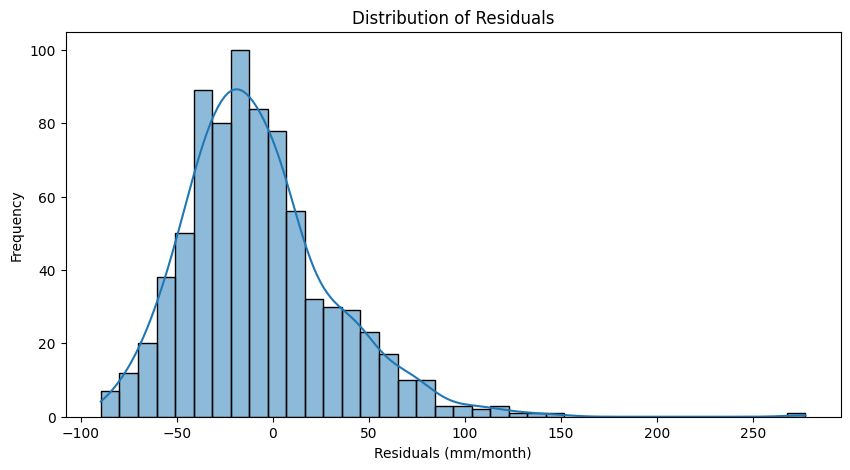

In [10]:
# Print the results
print("Test Mean Squared Error:", test_mse.values)
print("Test Root Mean Squared Error:", test_rmse.values)
print("Test Mean Error:", test_me.values)

# Plot the residuals
plt.figure(figsize=(10, 5))
sns.histplot(test_flattened_residuals, kde=True)  # Use the flattened residuals
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (mm/month)")
plt.ylabel("Frequency")
plt.show()

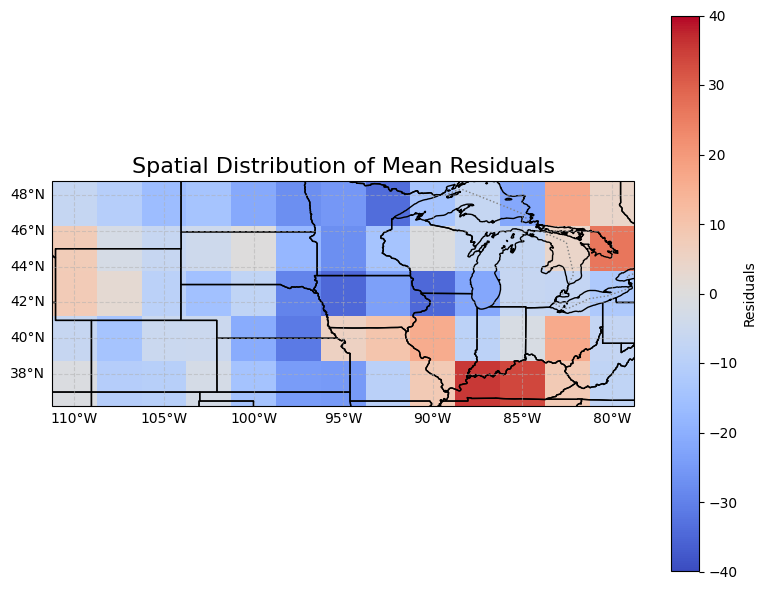

In [11]:
# Calculate the mean of the residuals along the time dimension
residuals_2d = test_residuals.mean(dim="time")

# Create a figure and axis with the PlateCarree projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot the test_residuals on the map
residuals_2d.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # Ensure correct projection
    cmap="coolwarm",  # Use a color map to distinguish positive and negative residuals
    cbar_kwargs={"label": "Residuals"},  # Add color bar label
    vmin=-40,
    vmax=40,
)

# Add geographic features
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")  # Country borders
ax.add_feature(cfeature.STATES, edgecolor="black")  # State boundaries
ax.coastlines()

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Title for the plot
ax.set_title("Spatial Distribution of Mean Residuals", fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()